<a href="https://colab.research.google.com/github/hit-Chris/phraug/blob/master/Assignment03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #3

In this algorithm, you will explore and compare some algorithms that we discussed over the past few weeks.
The first part will focus mostly on 2nd order algorithms.
The second part will explore the sparsification of DNN.


In [ ]:
import torch
import math
import torchvision
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_sched
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
torch.set_default_dtype(torch.float64)

## data generation

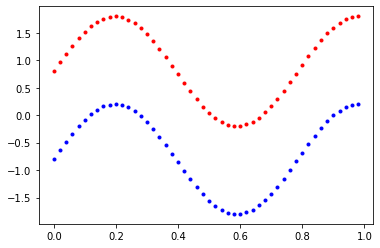

In [ ]:
def getData(num_pts = 50, freq = 8.0, offset = 0.8):
    """Get and return the data."""

    # Create array with num_pts points between 0 and 1 (i.e., 0,1/num_pts, 2/num_pts,...)
    xx = np.array(range(num_pts))*1.0/(num_pts+.0)
    # Create positive (xp) and negative (xn) classes
    xp = np.sin(freq*xx)+offset
    xn = np.sin(freq*xx)-offset

    # Concatenate the two arrays into list and reshape
    X = [ [xx.tolist()+xx.tolist()],[xp.tolist()+xn.tolist()]]
    X = np.reshape(np.array(X),[2,-1]) 

    # Create labels Y
    Y = [1 for _ in  range(num_pts)]
    Y = Y + [0 for _ in  range(num_pts)]

    ns = len(Y)
    Y = np.array(Y)
    X = np.transpose(X)
    y = np.zeros([ns,2])
    for i in range(ns):
        y[i,Y[i]] = 1

    return X,y  

X,y = getData()

plt.plot(X[y[:,0]==0,0],X[y[:,0]==0,1],'r.')
plt.plot(X[y[:,0]==1,0],X[y[:,0]==1,1],'b.')


In [ ]:

len(y)

100

## model
note, that this is very simple and not the correct way to define DNN to fit the data, but we just want to play with this and have "very" non-convex problem

In [ ]:
class Net(nn.Module):
  def __init__(self ):
      super(Net, self).__init__()
      self.fc0 = nn.Linear(2, 2)        
      self.fc1 = nn.Linear(2, 4)
      self.fc2 = nn.Linear(4,8)
      self.fc3 = nn.Linear(8,8)
      self.fc4 = nn.Linear(8,4)
      self.fc5 = nn.Linear(4,2)

  def forward(self, x):
      x = F.sigmoid(self.fc0(x))
      x = F.sigmoid(self.fc1(x))
      x = F.sigmoid(self.fc2(x))
      x = F.sigmoid(self.fc3(x))
      x = F.sigmoid(self.fc4(x))
      x = self.fc5(x)
      return  F.log_softmax(x,1)

torch.random.manual_seed(0)
model = Net()
w0 = [w+0.0 for w in model.parameters()]
d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)

Total parameters 176


# GD + Line-search [20pt]
Implement GD algorithm with a line search and try to train the model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


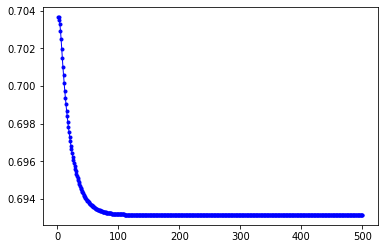

In [ ]:
torch.random.manual_seed(0)
model = Net()
w0 = [w+0.0 for w in model.parameters()]

loss_lis = []
ite_num = 500
optimizer = torch.optim.SGD(model.parameters(), lr=0.025)
scheduler = lr_sched.LinearLR(optimizer, start_factor=0.005)
for it in range(ite_num):
  optimizer.zero_grad()
  out = model(torch.tensor(X))
  loss = nn.CrossEntropyLoss()(out, torch.tensor(y))
  loss_lis.append(loss.item())
  loss.backward()
  optimizer.step()
  scheduler.step()
plt.plot(range(1,ite_num+1),loss_lis,'o-',ms=3,lw=1,color='blue')
plt.show()

# TR+CG [40pt]
Implement TR+CG algorithm and use it to train the DNN model 

In [ ]:
def normal_entropy(std):
    var = std.pow(2)
    entropy = 0.5 + 0.5 * torch.log(2 * var * math.pi)
    return entropy.sum(1, keepdim=True)


def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (
        2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)


def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))
    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size


def get_flat_grad_from(net, grad_grad=False):
    grads = []
    for param in net.parameters():
        if grad_grad:
            grads.append(param.grad.grad.view(-1))
        else:
            grads.append(param.grad.view(-1))
    flat_grad = torch.cat(grads)
    return flat_grad

def linesearch(model,
               f,
               x,
               fullstep,
               expected_improve_rate,
               max_backtracks=10,
               accept_ratio=.1):
    fval = f(True).data
    print("fval before", fval.item())
    for (_n_backtracks, stepfrac) in enumerate(.5**np.arange(max_backtracks)):
        xnew = x + stepfrac * fullstep
        set_flat_params_to(model, xnew)
        newfval = f(True).data
        actual_improve = fval - newfval
        expected_improve = expected_improve_rate * stepfrac
        ratio = actual_improve / expected_improve
        print("a/e/r", actual_improve.item(), expected_improve.item(), ratio.item())
        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            print("fval after", newfval.item())
            return True, xnew
    return False, x


def trpo_step(model, loss, get_kl, max_kl, damping):
    grads = torch.autograd.grad(loss, model.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        kl = get_kl()
        kl = kl.mean()

        grads = torch.autograd.grad(kl, model.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, model.parameters())
        flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * damping

    stepdir = conjugate_gradients(Fvp, -loss_grad, 10)

    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)
    print(("lagrange multiplier:", lm[0], "grad_norm:", loss_grad.norm()))

    prev_params = get_flat_params_from(model)
    success, new_params = linesearch(model, get_loss, prev_params, fullstep,
                                     neggdotstepdir / lm[0])
    set_flat_params_to(model, new_params)

    return loss

def conjugate_gradients(Avp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    for i in range(nsteps):
        _Avp = Avp(p)
        alpha = rdotr / torch.dot(p, _Avp)
        x += alpha * p
        r -= alpha * _Avp
        new_rdotr = torch.dot(r, r)
        betta = new_rdotr / rdotr
        p = r + betta * p
        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x

def conju_gd(x_0, Q):
  d_0 = grad(x_0)
  x_i = x_0
  d = d_0
  while grad(x_i) != 0:
    gamma = d.T*Q*grad(x_i) / d.T*Q*d
    d = -grad(x_i) + gamma * d
    lmd_i = - d.T * grad(x_i) / d.T*Q*d
    x_i = x_i + lmd_i * d
  return x_i

In [ ]:
data = torch.tensor(X)
target = torch.tensor(y)
output = model(data)
loss = F.mse_loss(output, target)
grad_f = torch.autograd.grad(loss, model.parameters(), create_graph = True)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [ ]:
Hessian = torch.zeros([d, d], device="cuda")
j = 0
for g in grad_f:
  g = g.view(-1)
  for i in range(g.numel()):
    Hv = torch.autograd.grad(g[i] , model.parameters(), create_graph=True)
    v = torch.cat([vi.reshape(-1) for vi in Hv]).detach()
    Hessian[:,j] = v 
    j+=1


In [ ]:
HessianNP = Hessian.cpu().data.numpy() 
print (np.max(np.abs(HessianNP-HessianNP.T)))
S,U = np.linalg.eig(HessianNP)
s = sorted(S+0.0)

1.1102230246251565e-16


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


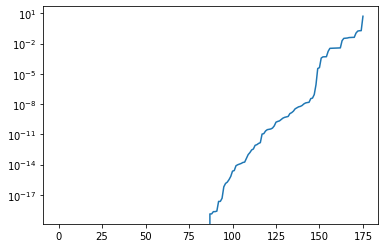

In [ ]:
plt.semilogy(s)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


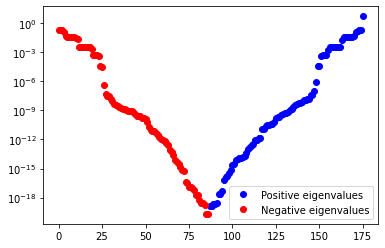

In [ ]:
plt.semilogy(s,'bo')
plt.semilogy(-np.array(s),'ro')
plt.legend(["Positive eigenvalues","Negative eigenvalues"])

In [ ]:
def setWeights(mymodel, wToSet):
  with torch.no_grad():
    for w, w0i in zip(mymodel.parameters(), wToSet):
      w.set_(w0i.data+0.0)

In [ ]:
torch.random.manual_seed(0)
setWeights(model, w0)      
eta = 5
etaHist = []
fval = []
dotProducts=[]
prevGrad = None
for it in range(2000):
  Ws = [w+0.0 for w in model.parameters()]
  output = model(data)
  loss = F.mse_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
  grad_f = torch.autograd.grad(loss, model.parameters())  # computation of gradient 
  if prevGrad is not None:
    dp = 0
    for pgi, gi in zip( prevGrad,  grad_f):
      dp+=torch.sum((gi-pgi )*(-pgi) ).item()
    dotProducts.append(dp)    
  
  sufficientDecrease = False
  j = 0
  while not sufficientDecrease:
    j+=1
    for w, g in zip(model.parameters(), grad_f):
      w.data.sub_(eta*g)
    output = model(data)
    lossNew = F.mse_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
    if j > 30 or lossNew < loss - eta*0.1 *eta*torch.sum(torch.stack([torch.norm(g)**2 for g in grad_f]) )  :
      etaHist .append(eta)
      fval.append(lossNew.item())
      eta = eta*2.0
      sufficientDecrease = True
    else:
      eta = eta*0.5
      setWeights(model, Ws)      
  prevGrad = grad_f

In [ ]:
dp = 0
for pgi, gi in zip( prevGrad,  grad_f):
  dp+=torch.sum((gi-pgi )*(-pgi) ).item()
dp

2.0547451113866858e-08

2.220446049250313e-16


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


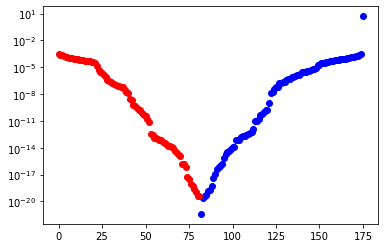

In [ ]:
output = model(data)
loss = F.mse_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
grad_f = torch.autograd.grad(loss, model.parameters(), create_graph=True)  # computation of gradient 

Hessian = torch.zeros([d,d],device="cuda")
j = 0
for g in grad_f:
  g = g.view(-1)
  for i in range(g.numel()):
    Hv = torch.autograd.grad(g[i] , model.parameters(), create_graph=True)
    v = torch.cat([vi.reshape(-1) for vi in Hv]).detach()
    Hessian[:,j] = v 
    j+=1
HessianNP = Hessian.cpu().data.numpy()  
print (np.max(np.abs(HessianNP-HessianNP.T)))
S,U = np.linalg.eig(HessianNP)
snew = sorted(S+0.0)
plt.semilogy(snew,'bo')
plt.semilogy(-np.array(snew),'ro')

In [ ]:
import os
import time
import datetime
import torch
torch.set_default_dtype(torch.float64)
torch.set_num_threads(1) #cpu num
from torch.jit import script, trace
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import csv
import random
import os
import itertools
import math
import numpy as np
import math
import torch.optim as optim
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from torch.nn.parameter import Parameter
from collections import OrderedDict
import sys


# stolen from Zheng Shi zhs310@lehigh.edu and Majid Jahani maj316@lehigh.edu
class TRCGOptimizer:
    def __init__(self,model,device,radius,cgopttol=1e-7,c0tr=0.2,c1tr=0.25,c2tr=0.75,t1tr=0.25,t2tr=2.0,radius_max=5.0,\
                 radius_initial=0.1):
        
        self.model = model
        self.device = device
        self.cgopttol = cgopttol
        self.c0tr = c0tr
        self.c1tr = c1tr
        self.c2tr = c2tr
        self.t1tr = t1tr
        self.t2tr = t2tr
        self.radius_max = radius_max
        self.radius_initial = radius_initial
        self.radius = radius
        self.cgmaxiter = 60
        
    def findroot(self,x,p):
        
        aa = 0.0
        bb = 0.0
        cc = 0.0
    
        for e in range(len(x)):
            aa += (p[e]*p[e]).sum()
            bb += (p[e]*x[e]).sum()
            cc += (x[e]*x[e]).sum()
        
        bb = bb*2.0
        cc = cc - self.radius**2
    
        alpha = (-2.0*cc)/(bb+(bb**2-(4.0*aa*cc)).sqrt())

        return alpha.data.item()
    
    
    def CGSolver(self,loss_grad,cnt_compute):
    
        cg_iter = 0 # iteration counter
        x0 = [] # define x_0 as a list
        for i in self.model.parameters():
            x0.append(torch.zeros(i.shape).to(self.device))
    
        r0 = [] # set initial residual to gradient
        p0 = [] # set initial conjugate direction to -r0
        self.cgopttol = 0.0
        
        for i in loss_grad:
            r0.append(i.data+0.0)     
            p0.append(0.0-i.data)
            self.cgopttol+=torch.norm(i.data)**2
        
        self.cgopttol = self.cgopttol.data.item()**0.5
        self.cgopttol = (min(0.5,self.cgopttol**0.5))*self.cgopttol
    
        cg_term = 0
        j = 0

        while 1:
            j+=1
    
            # if CG does not solve model within max allowable iterations
            if j > self.cgmaxiter:
                j=j-1
                p1 = x0
                print ('\n\nCG has issues !!!\n\n')
                break
            # hessian vector product
            loss_grad_direct = 0.0
            ind = 0
            for i in loss_grad:
                loss_grad_direct += (i*p0[ind]).sum()
                ind+=1
            Hp = torch.autograd.grad(loss_grad_direct,self.model.parameters(),retain_graph=True) # hessian-vector in tuple
            cnt_compute+=1
            
            pHp = 0.0 # quadratic term
            ind = 0
            for i in Hp:
                pHp += (p0[ind]*i).sum()
                ind+=1
    
            # if nonpositive curvature detected, go for the boundary of trust region
            if pHp.data.item() <= 0:
                tau = self.findroot(x0,p0)
                p1 = []
                for e in range(len(x0)):
                    p1.append(x0[e]+tau*p0[e])
                cg_term = 1
                break
            
            # if positive curvature
            # vector product
            rr0 = 0.0
            for i in r0:
                rr0 += (i*i).sum()
            
            # update alpha
            alpha = (rr0/pHp).data.item()
        
            x1 = []
            norm_x1 = 0.0
            
            
            for e in range(len(x0)):
                x1.append(x0[e]+alpha*p0[e])
                norm_x1 += torch.norm(x0[e]+alpha*p0[e])**2
            norm_x1 = norm_x1**0.5
            
            # if norm of the updated x1 > radius
            if norm_x1.data.item() >= self.radius:
                tau = self.findroot(x0,p0)
                p1 = []
                for e in range(len(x0)):
                    p1.append(x0[e]+tau*p0[e])
                cg_term = 2
                break
    
            # update residual
            r1 = []
            norm_r1 = 0.0
            for e in range(len(r0)):
                r1.append(r0[e]+alpha*Hp[e])
                norm_r1 += torch.norm(r0[e]+alpha*Hp[e])**2
            norm_r1 = norm_r1**0.5
    
            if norm_r1.data.item() < self.cgopttol:
                p1 = x1
                cg_term = 3
                break
    
            rr1 = 0.0
            for i in r1:
                rr1 += (i*i).sum()
    
            beta = (rr1/rr0).data.item()
    
            # update conjugate direction for next iterate
            p1 = []
            for e in range(len(r1)):
                p1.append(-r1[e]+beta*p0[e])
    
            p0 = p1
            x0 = x1
            r0 = r1
    

        cg_iter = j
        d = p1

        return d,cg_iter,cg_term,cnt_compute
    
    def step(self,loss,MSE,x_time_series,y_time_series):
        update = 2
        loss_grad = torch.autograd.grad(loss, self.model.parameters(), create_graph=True) 
        li_sm = 0
        for li in loss_grad:
          li_sum = li_sm + (li.data * li.data).sum()
        NormG = torch.sqrt(li_sum).data.item()
        # NormG = torch.sqrt(np.sum([(li.data * li.data).sum() for li in loss_grad])).data.item()
        ListG = [torch.sqrt((li.data*li.data).sum()) for li in loss_grad]
        cnt_compute=1
        
        # Conjugate Gradient Method
        d, cg_iter, cg_term, cnt_compute = self.CGSolver(loss_grad,cnt_compute)
        # current iterate
        w0 = []
        for i in self.model.parameters():
            w0.append(i.data.cpu().numpy())
    
        # update solution
        ind = 0
        for i in self.model.parameters():
            i.data = torch.from_numpy(w0[ind]).to(self.device)+d[ind]
            ind+=1
    
        # MSE loss plus penalty term
        with torch.no_grad():
            Pred_new = self.model(x_time_series)
            loss_new = MSE(Pred_new,y_time_series)

        numerator = loss.data.item() - loss_new.data.item()

        # dHd
        Hd = 0.0
        loss_grad_direct = 0.0
        ind = 0
        for i in loss_grad:
            loss_grad_direct += (i*d[ind]).sum()
            ind+=1
        Hd = torch.autograd.grad(loss_grad_direct,self.model.parameters()) # hessian-vector in tuple
        dHd = 0.0 # quadratic term
        ind = 0
        for i in Hd:
            dHd += (d[ind]*i.data).sum()
            ind+=1

        gd = 0.0
        ind = 0
        for i in loss_grad:
            gd += (i.data*d[ind]).sum()
            ind+=1

        norm_d = 0.0
        for i in d:
            norm_d += torch.norm(i)**2
        norm_d = norm_d**0.5
        
        denominator = -gd.data.item() - 0.5*(dHd.data.item())

        # ratio
        rho = numerator/denominator

        if rho < self.c1tr: # shrink radius
            self.radius = self.t1tr*self.radius
            update = 0
        if rho > self.c2tr and np.abs(norm_d.data.item() - self.radius) < 1e-10: # enlarge radius
            self.radius = min(self.t2tr*self.radius,self.radius_max)
            update = 1
        # otherwise, radius remains the same
        
        if rho <= self.c0tr: # reject d
            update = 3
            ind = 0
            for i in self.model.parameters():
                i.data = torch.from_numpy(w0[ind]).to(self.device)
                ind+=1
    
#         return d, rho, update, cg_iter, cg_term, loss_grad, norm_d, numerator, denominator, w0
        return self.radius, cnt_compute, cg_iter
        

In [ ]:
a = torch.tensor([1,2,3])
b = torch.tensor([4,5,6])
torch.sum(a)

tensor(6)

In [ ]:
setWeights(model, w0)      
radius_initial = 1.0
data = torch.tensor(X)
target = torch.tensor(y)
trVal = []
trCost = []

optimizer = TRCGOptimizer(model,"cuda",radius_initial)
for it in range(100):
  output = model(data)
  loss = F.mse_loss(output, target)  # The negative log likelihood loss.   https://pytorch.org/docs/stable/nn.functional.html#nll-loss
  print(loss.device)
  
  print(data.device)
  print(target.device)
  rad, cnt_compute, cgiter = optimizer.step(loss, F.mse_loss, data, target)
  
  print (it, loss.item(), cgiter)
  trVal.append(loss.item())
  trCost.append(1+cgiter)

cpu
cpu
cpu


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


AttributeError: ignored

# BFGS+Exact TR [40pt]
Implement BFGS algorithm to define the Hessian and then use CG algorithm to solve the gradratic subproblem.
Use this algorithm to train the DNN model 

In [ ]:
model = Net()
tu = []
for w in model.parameters():
  tu.append(w.data)
print(tu)

[tensor([[-0.6841,  0.3433],
        [-0.4965,  0.3670]]), tensor([-0.1852,  0.1391]), tensor([[ 0.3499, -0.5506],
        [ 0.4317, -0.0618],
        [ 0.4616, -0.4687],
        [-0.3393,  0.6344]]), tensor([-0.4884, -0.3228, -0.4484,  0.1425]), tensor([[-0.3756, -0.1153,  0.0975, -0.4029],
        [-0.4406,  0.1168, -0.3970, -0.3169],
        [-0.4939, -0.4978, -0.3380, -0.1399],
        [ 0.4271, -0.0154, -0.4654,  0.0314],
        [-0.1121, -0.2955, -0.0050, -0.3828],
        [-0.4182, -0.2539, -0.3109, -0.0162],
        [-0.2903,  0.0801,  0.4131, -0.0874],
        [ 0.4746,  0.4652, -0.1706, -0.3497]]), tensor([ 0.1505,  0.4087, -0.3685, -0.2469, -0.4935, -0.0940,  0.1877, -0.3853]), tensor([[-0.0800,  0.2309,  0.0045,  0.0978, -0.3473, -0.1455, -0.0441,  0.0709],
        [ 0.1745, -0.2956, -0.0173,  0.0200,  0.1934, -0.0844,  0.0064,  0.1005],
        [-0.1975,  0.0676, -0.2371, -0.0593, -0.2226,  0.0632,  0.1928,  0.1322],
        [-0.1104,  0.3325, -0.2552, -0.2167, -0.1184,  

In [ ]:
torch.random.manual_seed(0)
model = Net()
x = model.parameters()
w0 = [w+0.0 for w in model.parameters()]
S = []
s = []
Y = []
idx = []
memory  = 5
fvalLBFGS_LS = []
stepSize = 1.0
LS_hist = []
data = torch.tensor(X)
target = torch.tensor(y)
for it in range(2):
  out = model(data)
  loss = nn.CrossEntropyLoss()(out, target)
  grad_f = torch.autograd.grad(loss, model.parameters(), create_graph=True)
  
  fvalLBFGS_LS.append(loss.item())
  if it > 0:
    idx += grad_f
    Y.insert(0, idx)
    if len(Y) > memory:
      Y.pop()

  for a in model.parameters():
    s.append(-a.data)

  for a in grad_f:
    idx.append(-a.data)

  # q = -grad_f + 0.0
  # q = q.detach()
  if len(S) > 0:
    alphas = []
    rhos = []
    for i, (si, yi) in enumerate(zip(S, Y)):
      rho = 1 / (torch.dot(si, yi))
      rhos.append(rho)
    print(rhos)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1
2
3
4


In [ ]:
grad = 0
epsilon = 0.05
while np.linalg.norm(grad) ** 2 > epsilon:
  

# Adam [20pt]
Just use an Adam algorithm to to the same - train the DNN model

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


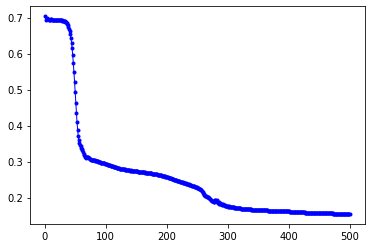

In [ ]:
torch.random.manual_seed(0)
model = Net() 
w0 = [w+0.0 for w in model.parameters()]
optimizer = torch.optim.Adam(model.parameters(), lr = 0.025)
loss_lis = []
for it in range(ite_num):
  optimizer.zero_grad()
  out = model(torch.tensor(X))
  loss = nn.CrossEntropyLoss()(out, torch.tensor(y))
  loss_lis.append(loss.item())
  loss.backward()
  optimizer.step()
plt.plot(range(1,ite_num+1),loss_lis,'o-',ms=3,lw=1,color='blue')
plt.show()


# Compare all of them [20pt]
Here, just try to compare all the algorithms developed above. How to make the comaparion fair? 

# IHT/L1 penalty for DNN [80pt]
*  we have discussed IHT algorithm for Comp. sensing. Now, we will explore two strategies to obtain sparse weights for our previous model. You should design the algorithms and explore how effective they are
*  the first formulation 
$$
\min_{w1, w_2, ... w_k}  CE( DNN(x_i), y_i ), \mbox{such that}\  \|w_i\|_0 \leq C_i
$$
where CE is a cross-entropy loss and DNN is our DNN model. Here we want to restric each fully connected layer (ignore biases) to have only 25\% elements non-zero (so pick $C_i$ accordingly)

*  the second appraoch is to add $\|\cdot\|_1$ penalty
$$
\min_{w1, w_2, ... w_k}  CE( DNN(x_i), y_i ) + \sum_i \lambda_i    \|w_i\|_1  
$$
play with $\lambda_i$'s to achive also sparse $w_i$'s 


In [ ]:
class Net(nn.Module):
  def __init__(self ):
      super(Net, self).__init__()
      self.fc0 = nn.Linear(2, 2)        
      self.fc1 = nn.Linear(2, 4)
      self.fc2 = nn.Linear(4, 8)
      self.fc3 = nn.Linear(8, 8)
      self.fc4 = nn.Linear(8, 4)
      self.fc5 = nn.Linear(4, 2)

  def forward(self, x):
      x = F.sigmoid(self.fc0(x))
      x = F.sigmoid(self.fc1(x))
      x = F.sigmoid(self.fc2(x))
      x = F.sigmoid(self.fc3(x))
      x = F.sigmoid(self.fc4(x))
      x = self.fc5(x)
      return  F.log_softmax(x,1)

torch.random.manual_seed(0)
model = Net()
w0 = [w+0.0 for w in model.parameters()]

d = np.sum([w.numel() for w in model.parameters()])
print ("Total parameters",d)


Total parameters 176


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


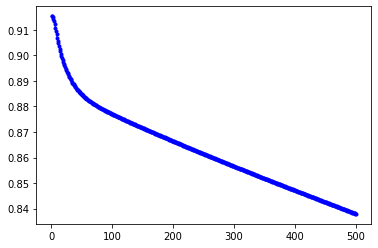

In [ ]:
torch.random.manual_seed(702)
model = Net()
loss_lis = []
ite_num = 500
optimizer = torch.optim.SGD(model.parameters(), lr=0.025)
scheduler = lr_sched.LinearLR(optimizer, start_factor=0.005)
for it in range(ite_num):
  optimizer.zero_grad()
  out = model(data)
  l1_w = 0.0
  for w in model.parameters():
    l1_w = l1_w + torch.sum(torch.abs(w))
  loss = F.cross_entropy(out, target)+0.005*l1_w
  loss_lis.append(loss.item())
  loss.backward()
  optimizer.step()
  scheduler.step()
plt.plot(range(1,ite_num+1),loss_lis,'o-',ms=3,lw=1,color='blue')
plt.show()